In [22]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import timeit
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.5, 4.5) # set default size of plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import timeit
import os

from smilebot import augmentations, features
from csvdb import truths, csvdb

np.random.seed(410)

pr_db = csvdb.Database('results/curves.csv')

models = [
    ('models/one_out_of_6_layers-sm-2-ffc-2d0.5-xl:3c4c-20190602-183014.savedmodel', "Embedded 3-layer"),
    ('models/experiment-20190601-133359.savedmodel', "Baseline AlexNet"),
    #('models/one_out_of_3_layers-20190601-160320.savedmodel', "Reduced AlexNet"),
    # ('models/one_out_of_4_layers-sm-2-20190602-170215.savedmodel', "Smaller 3-layer")  AUC=0.65
    
    ('models/one_out_of_3_layers-sm-220190602-162257.savedmodel', "Reduced AlexNet"),
    ('models/twolayerfc-20190603-221', "2-layer Fully Connected"),
]

Load the pickled validation set and its images

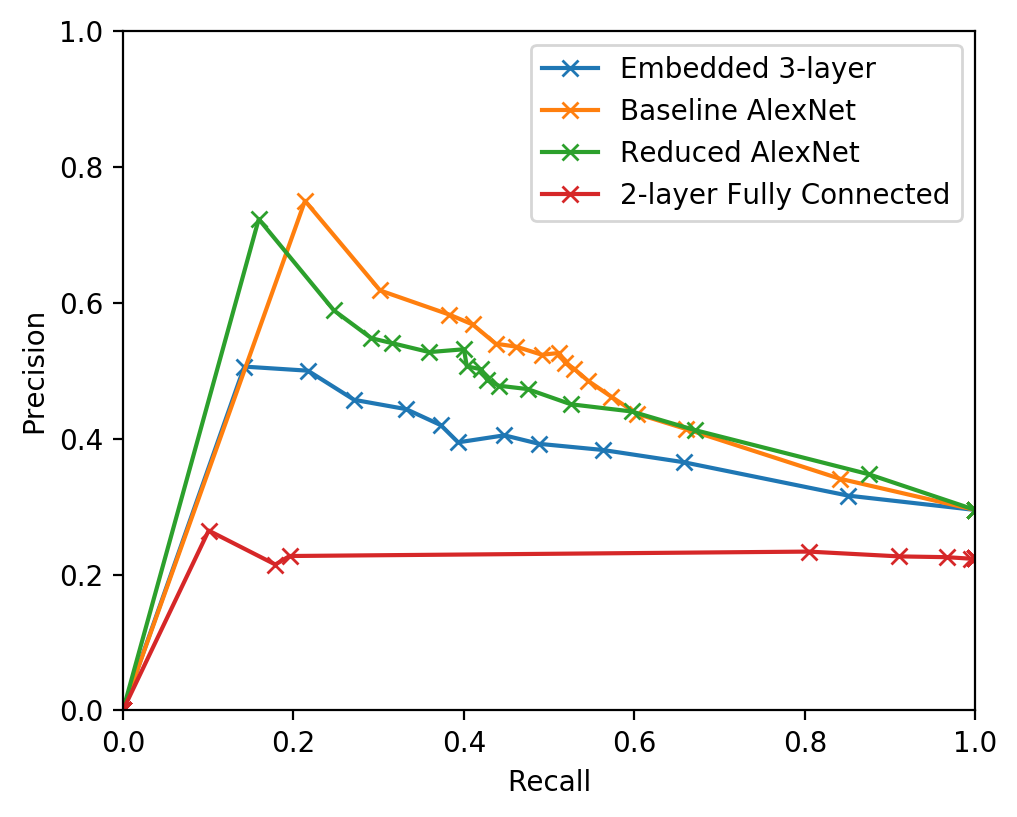

In [20]:
def load_and_plot(db, models, xm='recall_for_class', ym='precision_for_class', xlabel="Recall", ylabel="Precision", add=False):
    def clip(x):
        return min(1.0, max(0.0, x))
    for model, name in models:
        pairs = []
        auc = 0
        for k, v in db.db.items():
            if not v['model'].startswith(model): continue
            pairs.append((clip(float(v[xm] or 0.0)), clip(float(v[ym] or 0.0))))
            auc = v['auc_for_class']
        ps = sorted(pairs)
        x, y = zip(*ps)
        if add:
            name = name  + ' (auc={:.2f})'.format(float(auc))
        plt.plot(x, y, label=name, marker="x")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()
    #return x, y, ps

load_and_plot(pr_db, models)
plt.show()

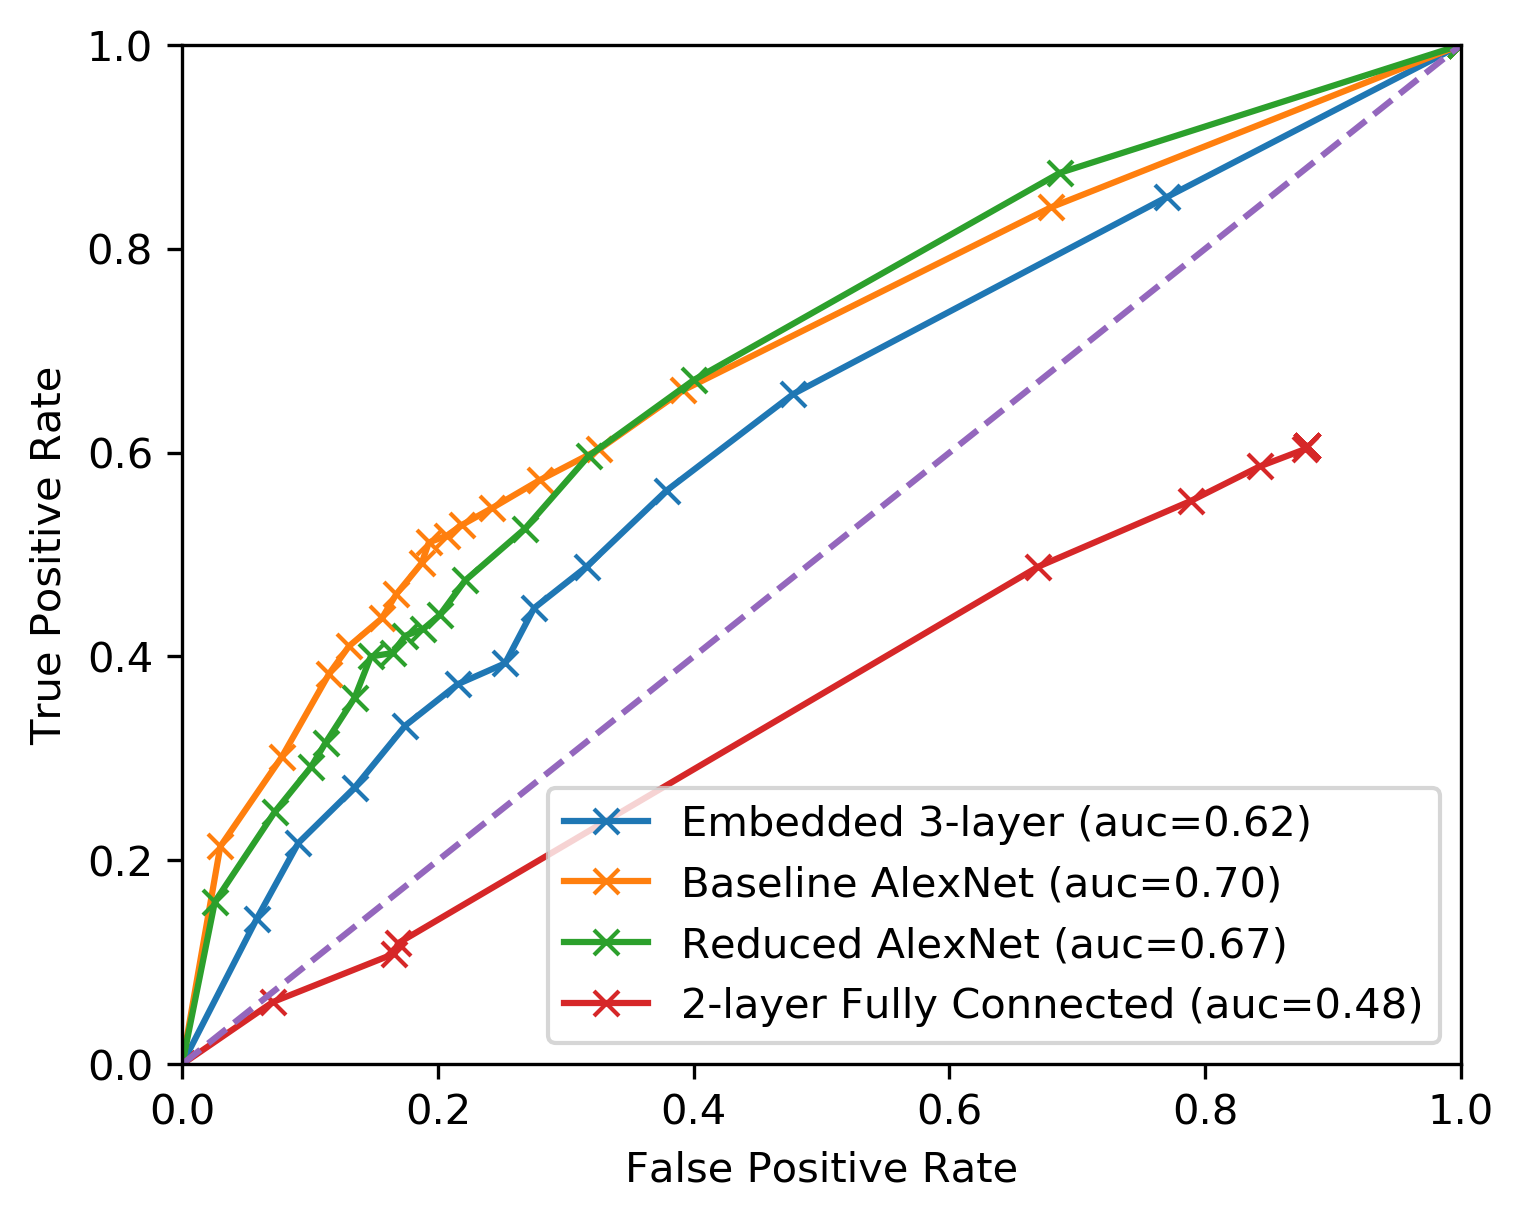

In [23]:
load_and_plot(pr_db, models,
              xm='false_pos_for_class', ym='true_pos_for_class',
              xlabel='False Positive Rate', ylabel="True Positive Rate",
              add=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

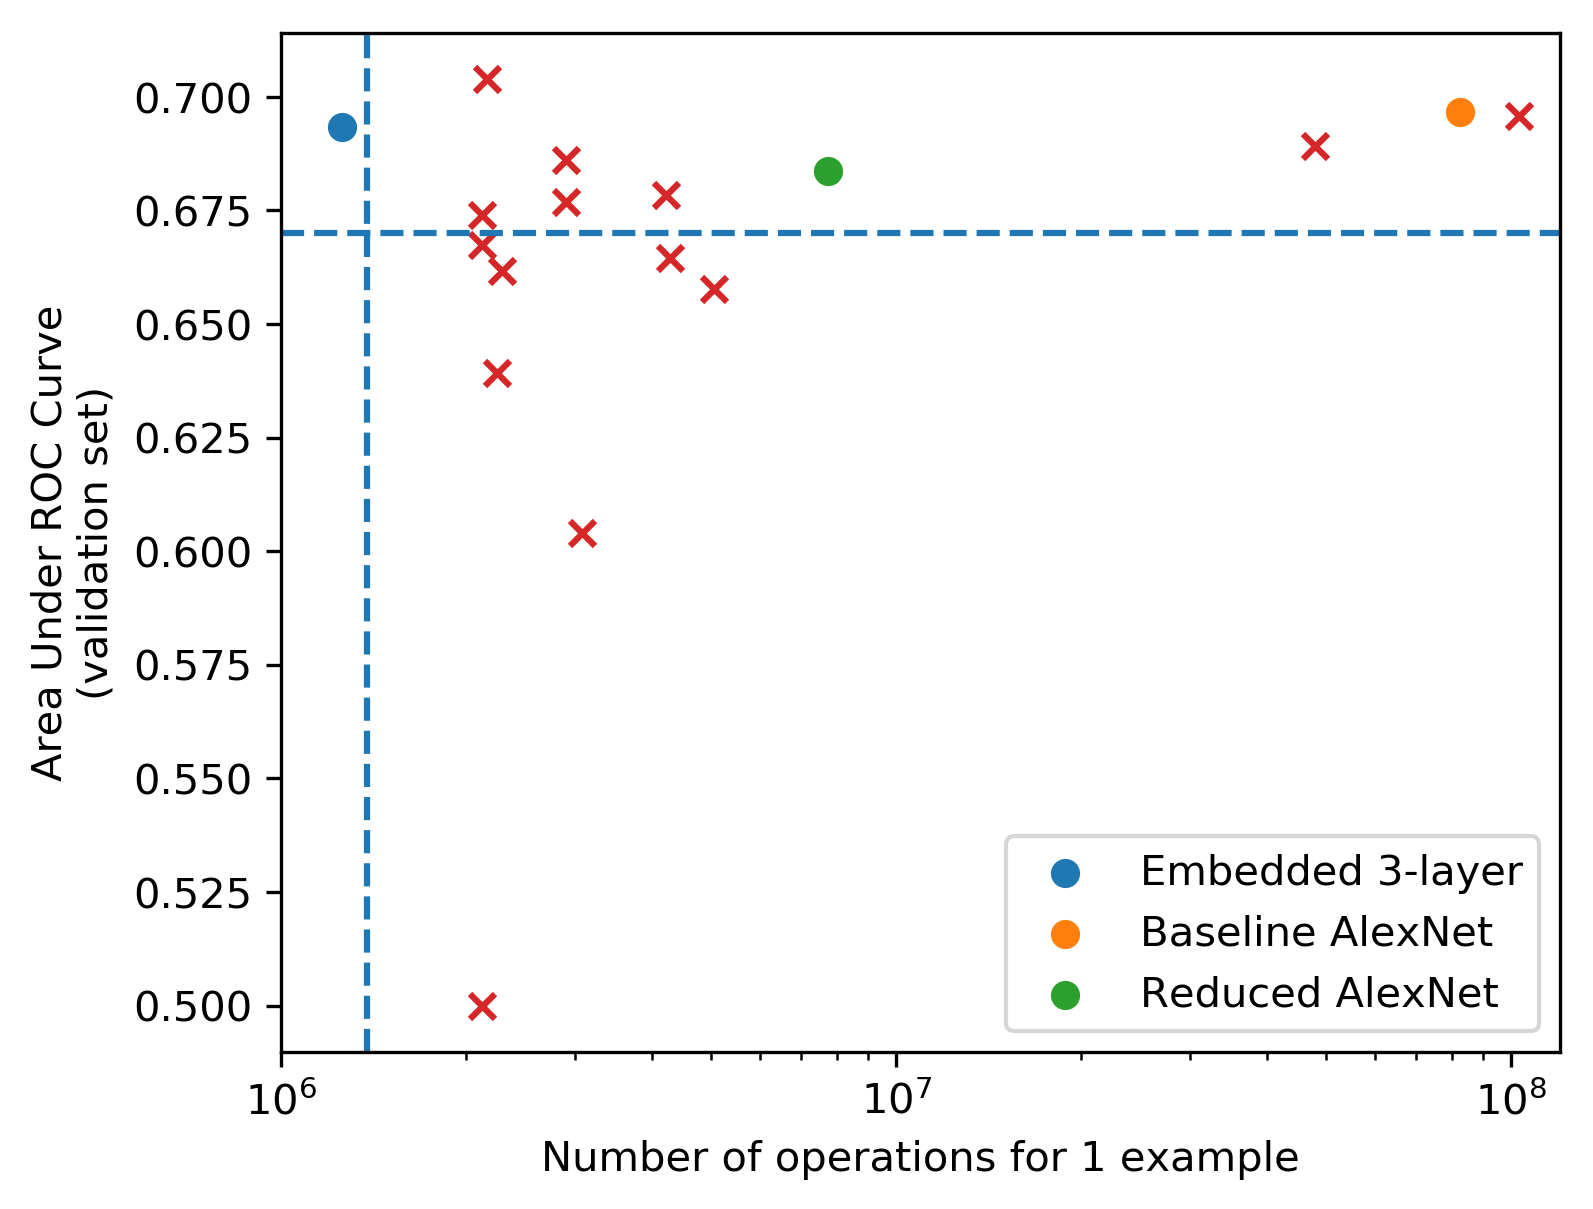

In [27]:
import numpy as np

profile_db = csvdb.Database('results/profiles.csv')

def load_and_plot_profile(db, models, xm='recall_for_class', ym='precision_for_class', xlabel="Recall", ylabel="Precision", add=False):
    done = {}
    for model, name in models:
        for k, v in db.db.items():
            if v['set'] != 'val' and name != 'Baseline AlexNet': continue
            if v['model'] != model: continue
            plt.scatter([float(v[xm] or 0.0)], [float(v[ym] or 0.0)], marker="o", label=name)
            done[model] = True
    
    pairs = []
    for k, v in db.db.items():
        if v['set'] != 'val': continue
        if v['model'] in done: continue
        pairs.append(((float(v[xm] or 0.0)), (float(v[ym] or 0.0))))
        ps = sorted(pairs)
        x, y = zip(*ps)
    plt.scatter(x, y, marker="x")

    
    
    #x = np.linscale
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.ylim(0,1)
    plt.xscale('log')
    plt.xlim(1e6, 1.2e8)
    plt.axhline(0.67, linestyle='--')
    plt.axvline(3 *0.46e6, linestyle='--')
    plt.legend()

plt.clf()
load_and_plot_profile(profile_db, models,
              xm='flops', ym='auc_for_class',
              xlabel='Number of operations for 1 example', ylabel="Area Under ROC Curve\n(validation set)")
plt.show()